In [1]:
# libraries
%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

/Users/nkochura@us.ibm.com/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("/Users/nkochura@us.ibm.com/Documents/ML_COMPETITION_DATAAI/https-github.ibm.com-ML4DevOps/data/grafana_data_cpu_http.csv")

df.head()

,timestamp,value,http
0,4/21/19 0:00,18.5,9244.0
1,4/21/19 0:15,15.2,9304.0
2,4/21/19 0:30,16.2,9364.0
3,4/21/19 0:45,19.2,9424.0
4,4/21/19 1:00,19.4,9484.0


In [3]:
print(df.info())
#
df['http'] = df['http'].astype(float)
print (df['http'].mean()) 
print(df['value'].mean())
print(df['timestamp'].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 3 columns):
timestamp    673 non-null object
value        673 non-null float64
http         673 non-null float64
dtypes: float64(2), object(1)
memory usage: 15.9+ KB
None
9872.84398216939
17.188261515601784
0    4/21/19 0:00
1    4/21/19 0:15
2    4/21/19 0:30
3    4/21/19 0:45
4    4/21/19 1:00
5    4/21/19 1:15
6    4/21/19 1:30
7    4/21/19 1:45
8    4/21/19 2:00
9    4/21/19 2:15
Name: timestamp, dtype: object


0   2019-04-21 00:00:00
1   2019-04-21 00:15:00
2   2019-04-21 00:30:00
3   2019-04-21 00:45:00
4   2019-04-21 01:00:00
5   2019-04-21 01:15:00
6   2019-04-21 01:30:00
7   2019-04-21 01:45:00
8   2019-04-21 02:00:00
9   2019-04-21 02:15:00
Name: timestamp, dtype: datetime64[ns]


<IPython.core.display.Javascript object>


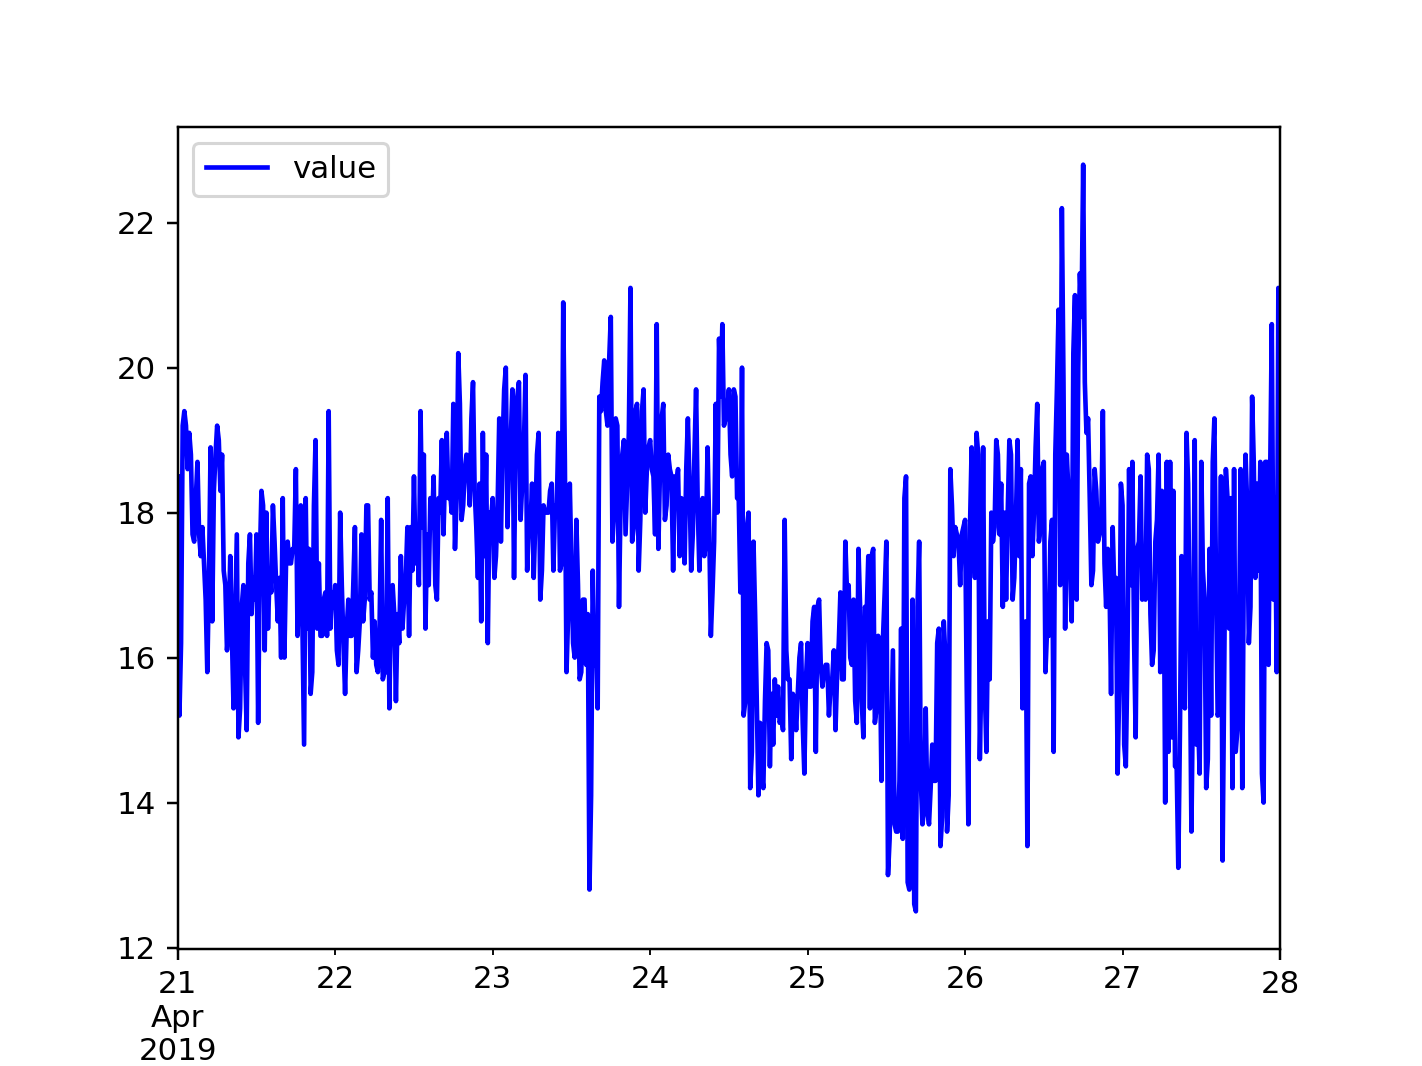

<IPython.core.display.Javascript object>


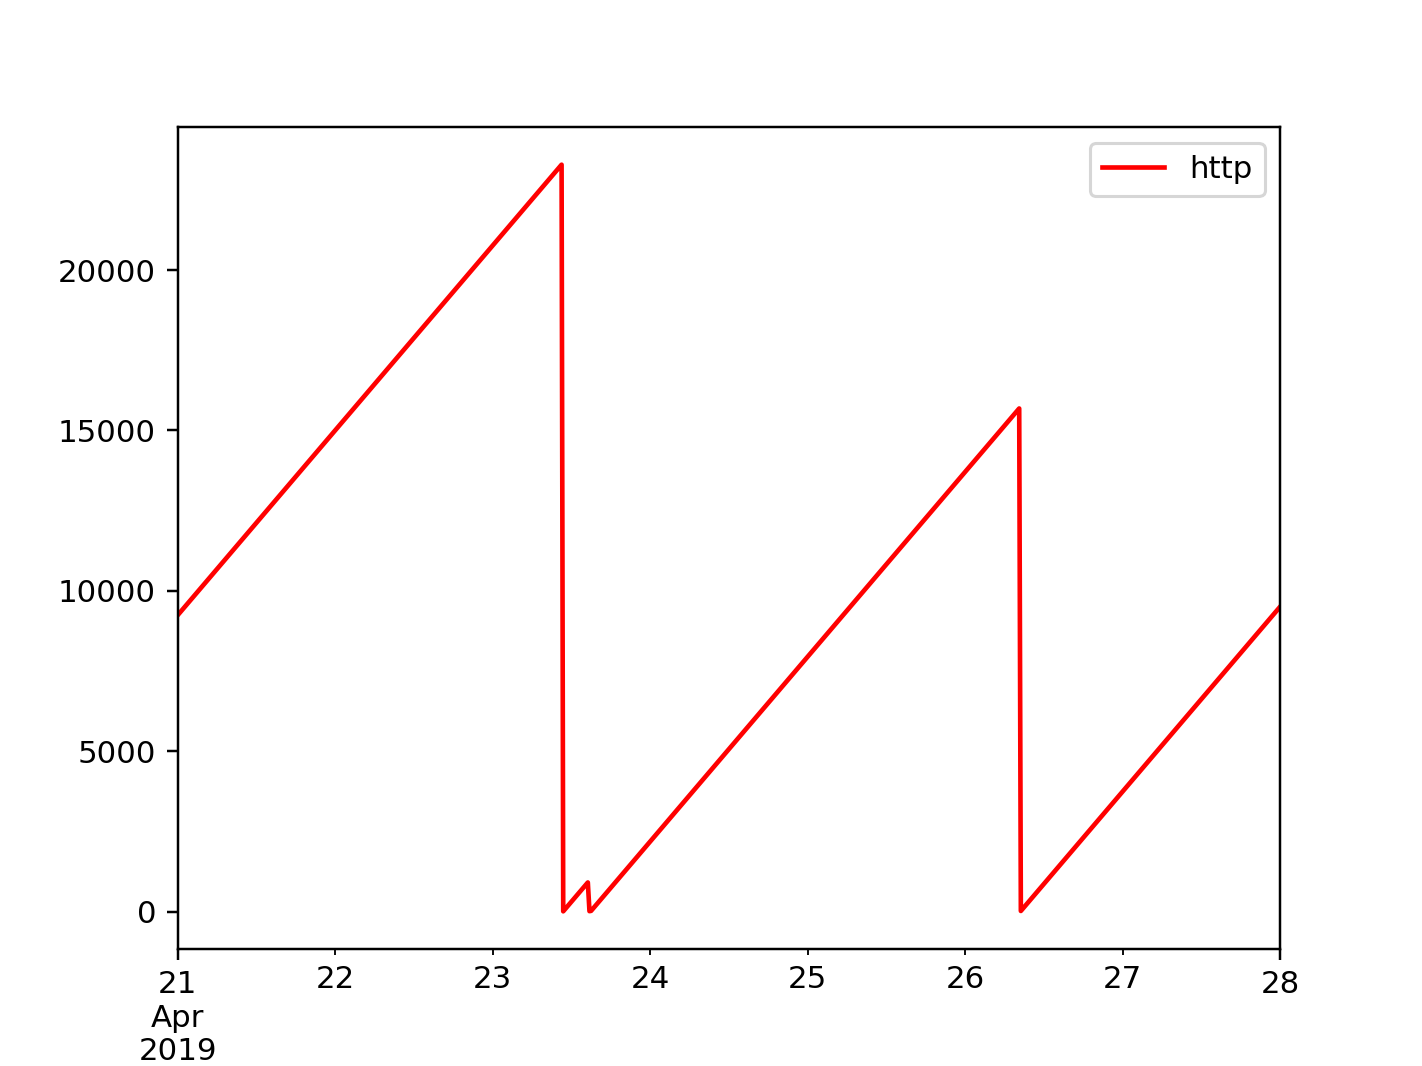

In [4]:
# change the type of time  column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df['timestamp'].head(10))
# df['value'] = (df['value'] + 10) * 1/10
# plot the data
df.plot(x='timestamp', y='value',color='blue')
df.plot(x='timestamp', y='http',color='red')

Categorize http load :"low":0 ,"medium":1,"high":2

<IPython.core.display.Javascript object>


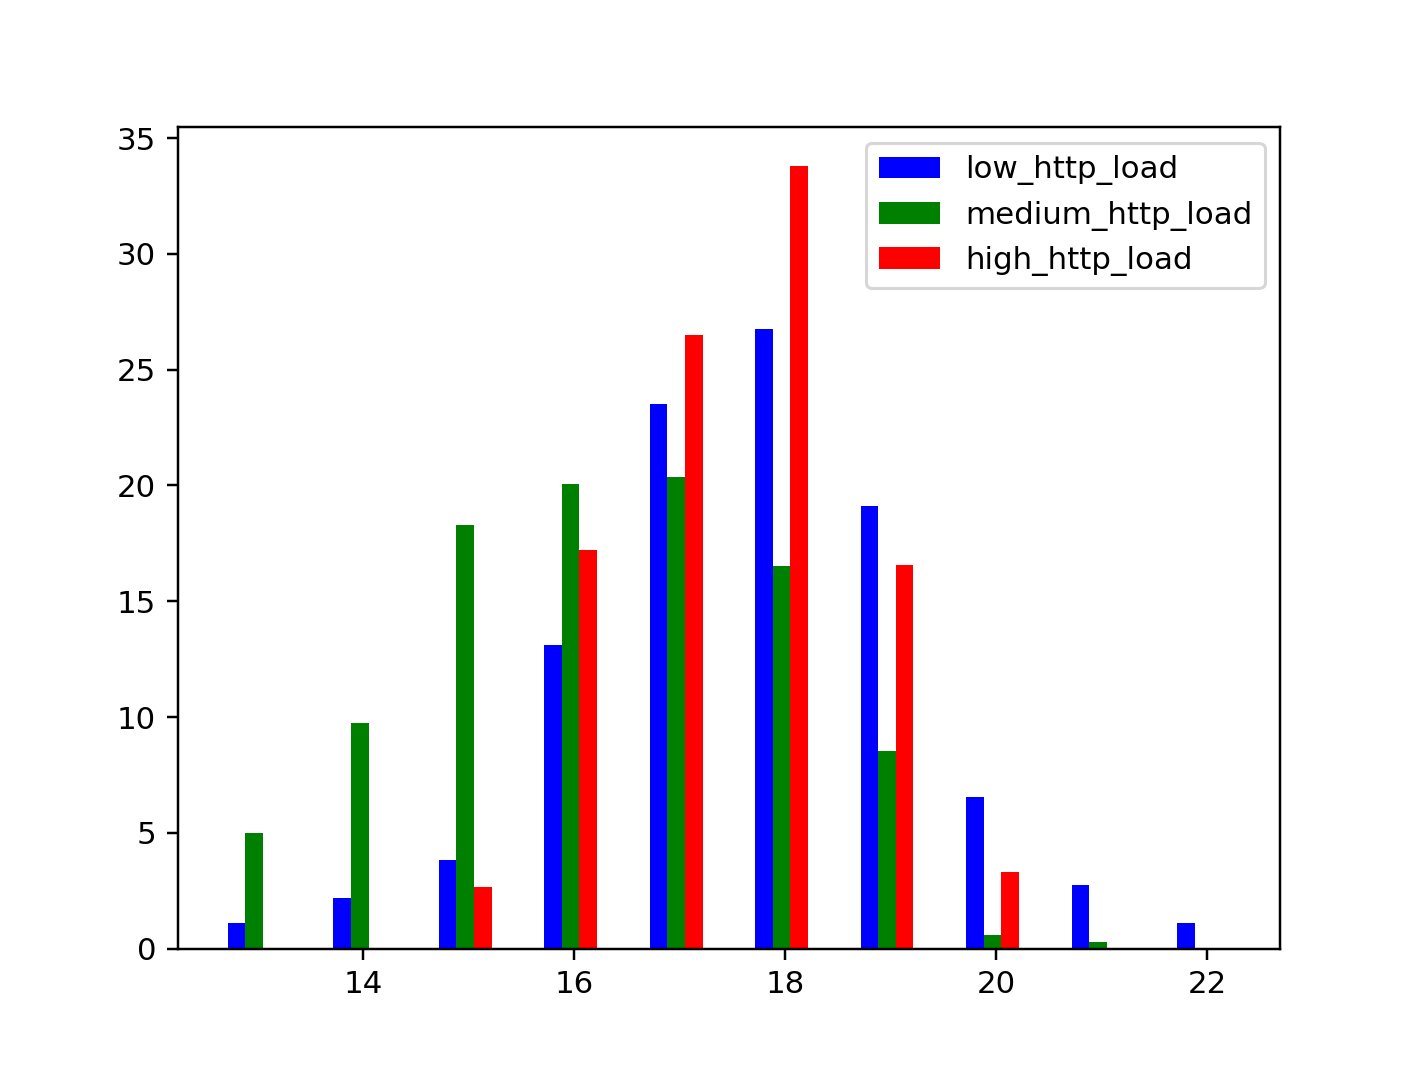

In [5]:
#print (df.dtypes)
df ['cat'] = 1 
df['highload'] = ((df['http'] >= 15000.0)).astype(int)
df['lowload'] = ((df['http'] <= 5000.0)).astype(int) 

# An estimation of anomly population of the dataset 
outliers_fraction = 0.01
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
# creation of 3 distinct categories 
df ['cat'] = df ['cat'] + df['highload'] - df['lowload']

a = df.loc[df['cat'] == 0, 'value']
b = df.loc[df['cat'] == 1, 'value']
c = df.loc[df['cat'] == 2, 'value']


fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)


width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='low_http_load')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='medium_http_load')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='high_http_load')

plt.legend()
plt.show()

# Cluster based anomlalies

We group together the combination of features. The points that are far from the cluster are points with usual combination of features we consider those points as anomalies.

One class SVM

In [6]:
# Take useful feature and standardize them 
data = df[['value', 'http', 'cat']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly1'] = pd.Series(model.predict(data))
df['anomaly1'] = df['anomaly1'].map( {1: 0, -1: 1} )
print(df['anomaly1'].value_counts())

0    663
1     10
Name: anomaly1, dtype: int64


<IPython.core.display.Javascript object>


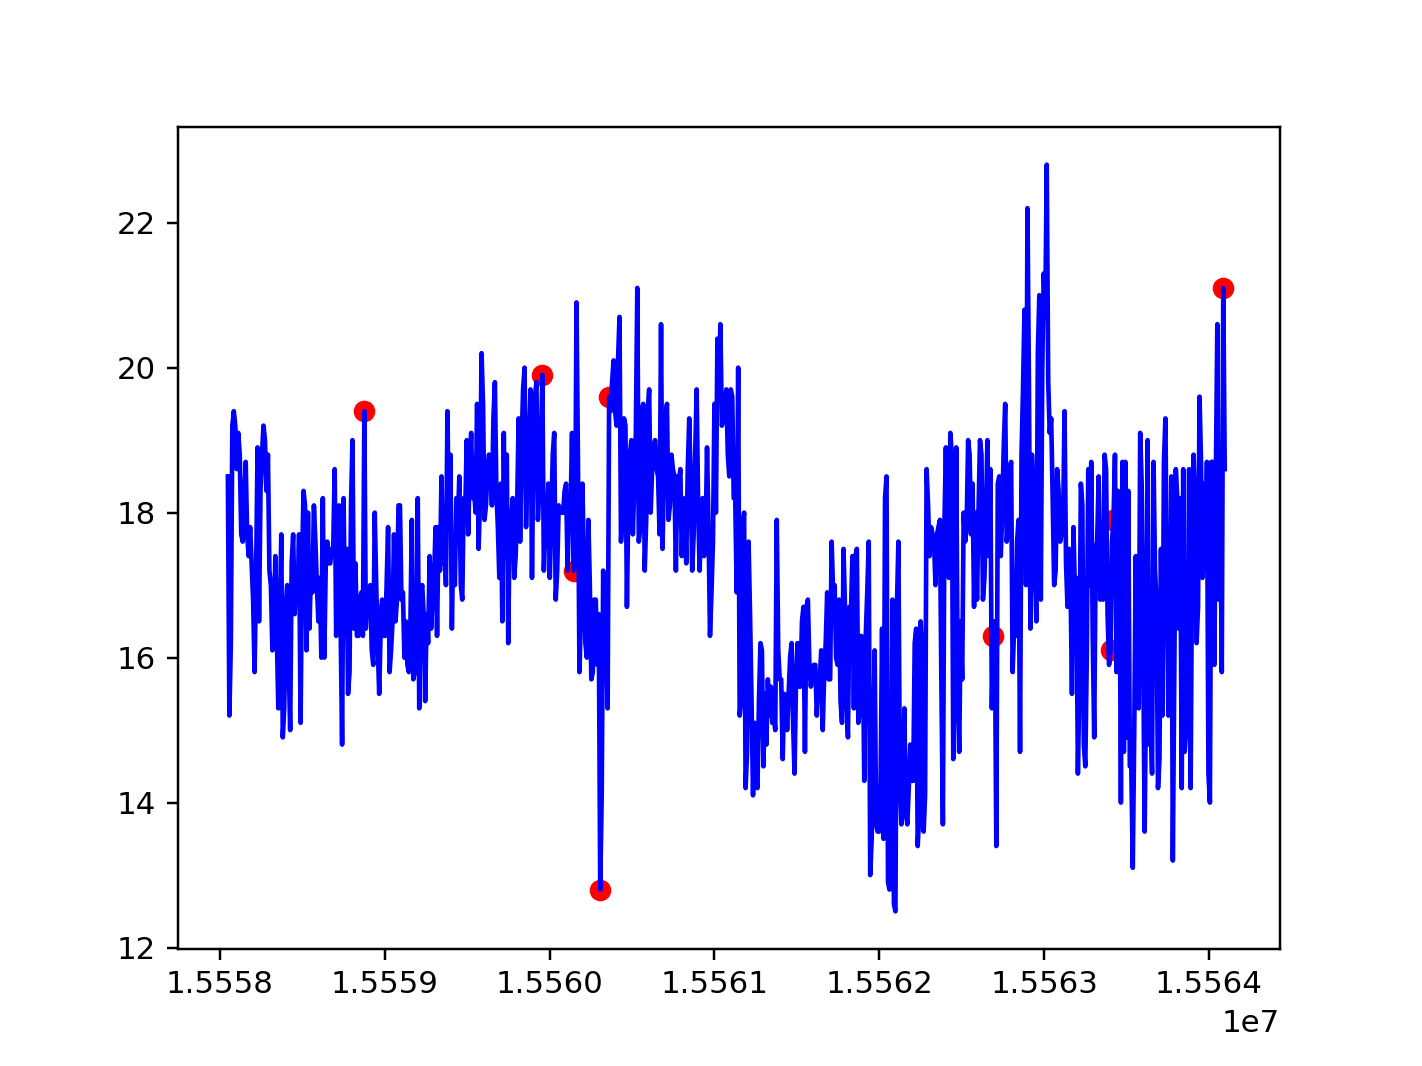

In [7]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly1'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>


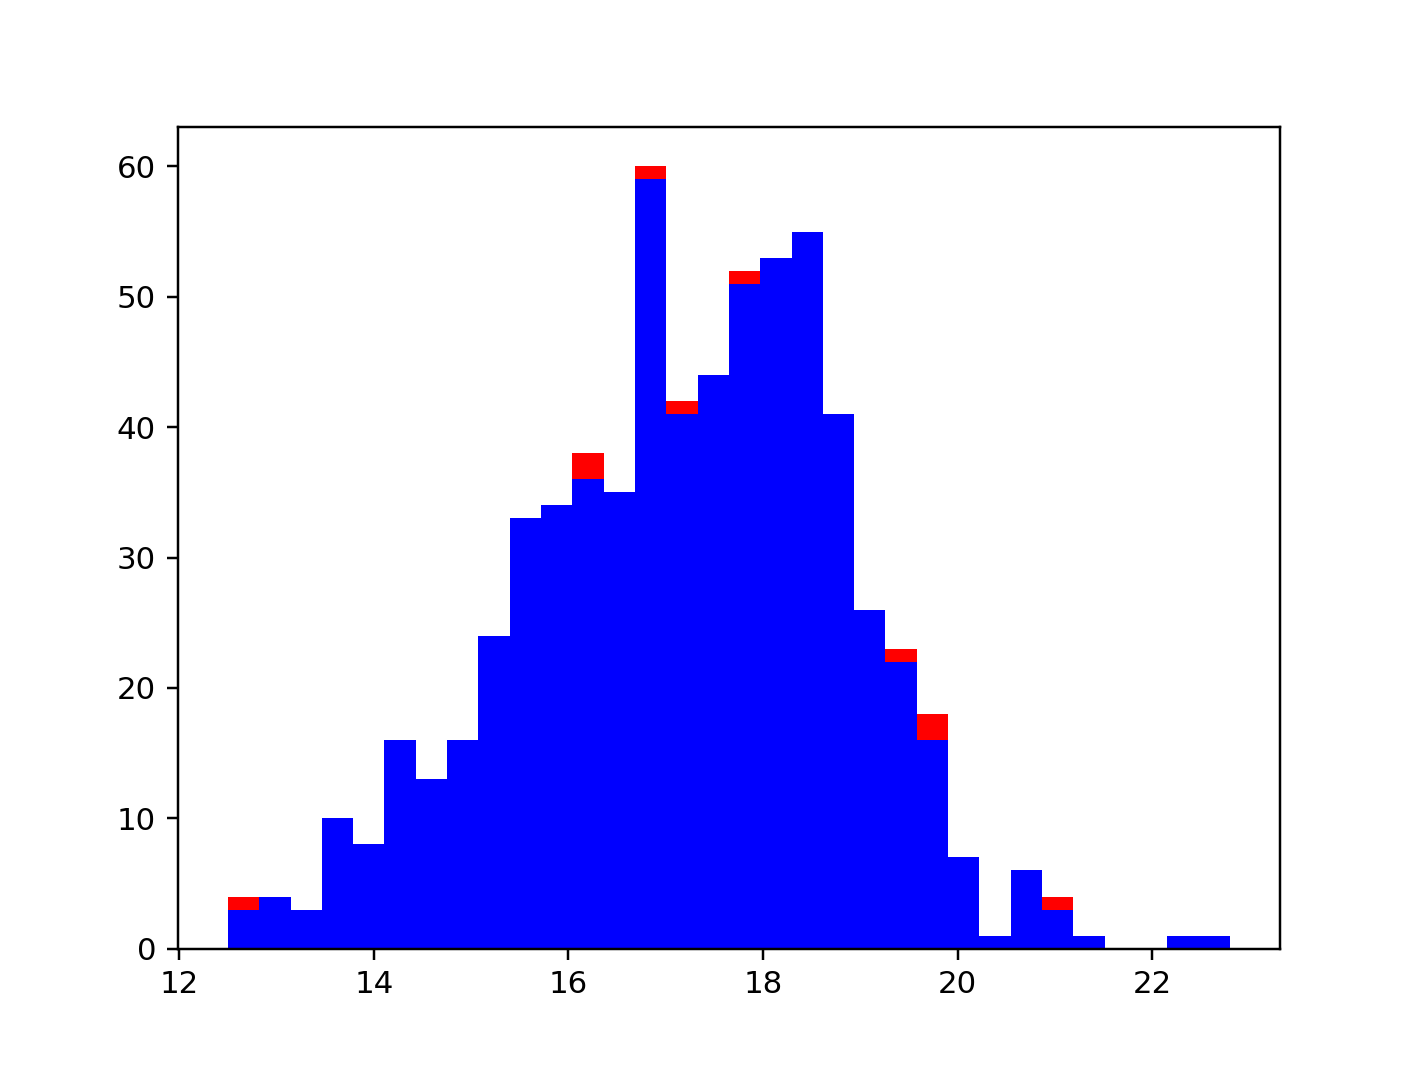

/Users/nkochura@us.ibm.com/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [8]:
# visualisation of anomaly with http _load repartition(viz 2)
a = df.loc[df['anomaly1'] == 0, 'value']
b = df.loc[df['anomaly1'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()